# Statistical Analysis <a id='stats'></a>

[Data quality](#qa)
[Behavioral results](#beh)
[Brain graph metrics](#graph)
[Mean FC](#fc)
[Regression analyses](#reg)

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

sns.set_palette('Set1')

/usr/local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [3]:
import re

hc = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/hc_dmn_fpn.csv')
hc['subject'] = hc['subject'].astype(str)
print('hc', hc.shape)

q_global = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/modularity_global_mean.csv')
q_global['subject'] = q_global['subject'].astype(str)
q_global['q_global'] = q_global[[col for col in q_global.columns if 'mod_global' in col]].mean(axis=1, skipna=True)
print('q', q_global.shape)

pc_global = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/pc_global_mean.csv')
pc_global['subject'] = pc_global['subject'].astype(str)
pc_global['pc_global'] = pc_global[[col for col in pc_global.columns if 'pc_global' in col]].mean(axis=1, skipna=True)

edgesdf = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/edgesdf.csv')
edgesdfInt = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/edgesdf_accInt.csv')

edgesdf['subject'] = edgesdf['subject'].astype(str)
edgesdfInt['subject'] = edgesdfInt['subject'].astype(str)

df0 = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/data/dataset_2021-11-10.csv')
df0['subject'] = df0['subject'].astype(str)
print('df0', df0.shape)

cr = pd.read_csv('/Users/PSYC-mcm5324/Library/CloudStorage/Box-Box/CogNeuroLab/Aging Decision Making R01/data/actigraphy/circadian_measures/7_days/circadian_rhythms_2021-06-14.csv')
cr['subject'] = cr['record_id'].astype(str)

df = pd.merge(hc, q_global, on='subject', how='outer')
df = pd.merge(df, pc_global, on='subject', how='outer')
df = pd.merge(df, edgesdf, on='subject', how='outer')
df = pd.merge(df, edgesdfInt, on='subject', how='outer')
df = pd.merge(df, df0, on='subject', how='outer')
df = df.drop(['actamp', 'actphi'], axis=1)
df = pd.merge(df, cr, on='subject', how='outer')

df = df.dropna(subset=['hc_dmn_fc']).drop(['edge_0', 'edge_1', 'edge_2', 'edge_3'], axis=1)
df['Group'] = np.where(df['subject'].astype(int) > 40000, "Older Adults", "Young Adults")
df = df.set_index('subject')
df['acc_mean_learning_log'] = np.log10(df['acc_mean_learning'])
df

hc (88, 6)
q (83, 8)
df0 (122, 781)


,hc_dmn_fc,hc_fpn_fc,dmn_fpn_fc,dmn_fc,fpn_fc,mod_global_10,mod_global_12,mod_global_14,mod_global_16,mod_global_18,...,actmin_y,actmesor_y,actupmesor_y,actdownmesor_y,actalph_y,actwidthratio_y,rsqact_y,fact_y,fnlrgact_y,acc_mean_learning_log
subject,,,,,,,,,,,,,,,,,,,,,
30004,0.246789,0.065381,0.172766,0.329363,0.480001,0.444238,0.420693,0.408654,0.385765,0.367548,...,0.110354,0.890183,6.700172,22.779248,-0.508936,0.669961,0.334222,3689.465997,1461.775352,-0.037789
30008,0.460457,0.254719,0.275094,0.418964,0.495840,0.528734,0.502317,0.474441,0.452302,0.429773,...,0.162260,0.944128,7.692367,23.248098,-0.448818,0.648155,0.414651,5657.133592,2618.443375,-0.024824
30009,0.130394,0.029481,0.099538,0.228084,0.435712,0.413678,0.391237,0.365807,0.345061,0.327857,...,0.000000,0.949817,6.549198,22.670141,-0.513646,0.671706,0.379630,4456.146897,1181.803552,-0.012234
30015,-0.016112,-0.156934,0.079484,0.230274,0.300856,0.389794,0.361667,0.340291,0.319213,0.309240,...,0.126022,0.920032,6.021173,22.095209,-0.508368,0.669752,0.421492,6268.750715,2818.222213,-0.012234
30019,0.048041,-0.003531,0.186824,0.230634,0.389143,0.393851,0.374114,0.363323,0.339624,0.324801,...,0.028576,0.850904,8.317360,24.576819,-0.529117,0.677477,0.354536,4409.974289,1349.024805,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40803,0.350450,0.229242,0.298179,0.412727,0.366239,0.344091,0.310300,0.300083,0.285101,0.273344,...,0.080274,0.841092,7.750680,21.669804,-0.248577,0.579963,0.413767,6090.933543,1387.084346,-0.109144
40855,0.091679,-0.178049,0.108382,0.236406,0.336743,0.394147,0.373889,0.348353,0.330276,0.317969,...,0.110739,0.748081,7.615581,22.701207,-0.393013,0.628568,0.330172,4967.787241,2174.797104,-0.234083
40861,0.145420,0.042649,0.354432,0.414590,0.416168,0.405554,0.375410,0.349587,0.332670,0.316307,...,0.407023,0.907023,4.857207,20.923823,-0.507531,0.669442,0.130006,1399.706506,805.383223,-0.158362


## Data quality <a id='qa'></a>

In [4]:
print('total size dataframe', df.shape)
df=df.dropna(subset=['actamp', 'actphi'])
print('total with cr data', df.shape)
df=df.dropna(subset=['acc_mean_learning', 'acc_mean_test'])
print('total with task data', df.shape)
df = df[(df['acc_mean_learning'] > 0.33)]
print('performed above chance on learning', df.shape)
df = df[(df['acc_mean_test'] > 0.55)]
print('performed above chance on task', df.shape)

pd.set_option("display.precision", 2)

# behresults = df[['acc_mean_learning', 'acc_std_learning', 'rt_c_mean_learning', 'rt_c_std_learning', 'acc_mean_test', 'acc_std_test', 'rt_c_mean_test', 'rt_c_std_test', 'Group']].groupby('Group').describe().T
# behresults.reindex(columns=['Young Adults', 'Older Adults']).to_latex('/Users/PSYC-mcm5324/Desktop/memtaskresults.tex')


total size dataframe (88, 846)
total with cr data (83, 846)
total with task data (73, 846)
performed above chance on learning (73, 846)
performed above chance on task (73, 846)


## Behavioral results <a id='beh'></a>

### Task

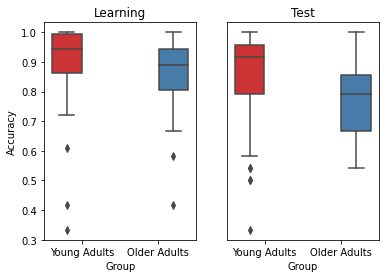

In [5]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='acc_mean_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='acc_mean_test', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('/Users/PSYC-mcm5324/Desktop/accuracy.png', dpi=300)

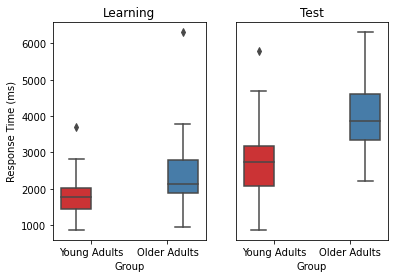

In [6]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='rt_c_mean_learning', hue='Group', ax=axes[0]).set(title='Learning');
axes[0].set_ylabel('Response Time (ms)'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='rt_c_mean_test', hue='Group', ax=axes[1]).set(title='Test');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('/Users/PSYC-mcm5324/Desktop/rtc.png', dpi=300)

In [7]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_mean_learning'].dropna(), df[df['Group'] == "Older Adults"]['acc_mean_learning'].dropna())

Ttest_indResult(statistic=1.2278225661267226, pvalue=0.22356864710279245)

In [8]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_mean_learning'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_mean_learning'].dropna())

Ttest_indResult(statistic=-3.468074295140669, pvalue=0.0008945510281887117)

In [9]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['acc_mean_test'].dropna(), df[df['Group'] == "Older Adults"]['acc_mean_test'].dropna())

Ttest_indResult(statistic=1.9802448524704443, pvalue=0.05155209897179327)

In [10]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['rt_c_mean_test'].dropna(), df[df['Group'] == "Older Adults"]['rt_c_mean_test'].dropna())

Ttest_indResult(statistic=-5.527353421094281, pvalue=5.069926721619371e-07)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='acc_mean_learning_log', ylabel='Density'>

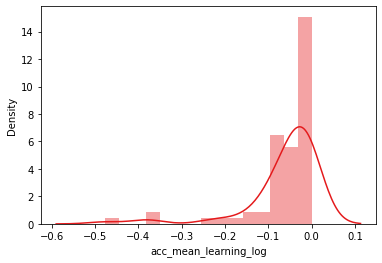

In [11]:
sns.distplot(df['acc_mean_learning_log'].dropna())

### RAR/Sleep

In [12]:
pg.corr(df['actamp'], df['sleep_time_mean_sleep'])

,n,r,CI95%,p-val,BF10,power
pearson,70,-0.31,"[-0.51, -0.08]",8.18e-03,4.585,0.76


In [13]:
pg.corr(df['actamp'], df['sleep_efficiency'])

,n,r,CI95%,p-val,BF10,power
pearson,70,-0.2,"[-0.41, 0.04]",0.1,0.558,0.38


In [14]:
pg.corr(df['actamp'], df['total_ac_mean_active'])

,n,r,CI95%,p-val,BF10,power
pearson,70,0.3,"[0.07, 0.5]",0.01,3.488,0.73


In [15]:
from scipy import stats
stats.ttest_ind(df[df['sex'] == 'Male']['actamp'].dropna(), df[df['sex'] == 'Female']['actamp'].dropna())

Ttest_indResult(statistic=-1.2863981761425178, pvalue=0.2026667427921726)

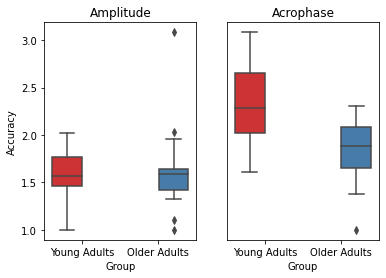

In [16]:
sns.set_palette('Set1')
fig, axes = plt.subplots(1,2)

sns.boxplot(data=df, x='Group', y='actamp', hue='Group', ax=axes[0]).set(title='Amplitude');
axes[0].set_ylabel('Accuracy'); axes[0].get_legend().remove()

sns.boxplot(data=df, x='Group', y='actphi', hue='Group', ax=axes[1]).set(title='Acrophase');
plt.ylabel(''); axes[1].yaxis.set_visible(False); axes[1].get_legend().remove()
plt.savefig('/Users/PSYC-mcm5324/Desktop/rar.png', dpi=300)

In [17]:
df[['actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'Group']].groupby('Group').describe().T

Group                        Older Adults  Young Adults
actamp                count         27.00      4.60e+01
                      mean           1.60      1.60e+00
                      std            0.37      2.35e-01
                      min            1.00      1.00e+00
                      25%            1.42      1.46e+00
                      50%            1.59      1.57e+00
                      75%            1.64      1.77e+00
                      max            3.08      2.02e+00
actphi                count         27.00      4.60e+01
                      mean          14.78      1.65e+01
                      std            1.23      1.51e+00
                      min           11.44      1.38e+01
                      25%           13.99      1.54e+01
                      50%           14.88      1.64e+01
                      75%           15.66      1.79e+01
                      max           16.52      1.95e+01
sleep_time_mean_sleep count         27.00      4.30e+01
                      mean         403.98      4.00e+02
                      std           94.78      9.82e+01
                      min          156.14      2.07e+02
                      25%          356.30      3.58e+02
                      50%          417.71      3.96e+02
                      75%          449.64      4.33e+02
                      max          604.57      9.01e+02
total_ac_mean_active  count         27.00      4.30e+01
                      mean      260296.82      3.21e+05
                      std       100302.92      1.90e+05
                      min       129848.14      1.67e+05
                      25%       192702.29      2.45e+05
                      50%       242060.57      2.74e+05
                      75%       329924.50      3.26e+05
                      max       570137.43      1.32e+06

In [18]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['sleep_time_mean_sleep'].dropna(), df[df['Group'] == "Older Adults"]['sleep_time_mean_sleep'].dropna())


Ttest_indResult(statistic=-0.15538415959875787, pvalue=0.8769788011311253)

In [19]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['total_ac_mean_active'].dropna(), df[df['Group'] == "Older Adults"]['total_ac_mean_active'].dropna())



Ttest_indResult(statistic=1.5268624735064387, pvalue=0.1314334618151261)

In [20]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['sleep_efficiency'].dropna(), df[df['Group'] == "Older Adults"]['sleep_efficiency'].dropna())




Ttest_indResult(statistic=0.9045045361086698, pvalue=0.36892138585572176)

## Global brain network metrics <a id='graph'></a>

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


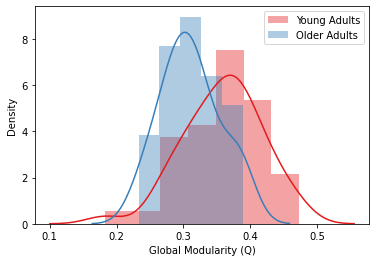

In [21]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_global'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_global'].dropna(), label = 'Older Adults')
plt.xlabel('Global Modularity (Q)')
plt.legend()
plt.savefig(results_dir + 'global_modularity.png', dpi=300)

In [22]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global'].dropna(), df[df['Group'] == "Older Adults"]['q_global'].dropna())

Ttest_indResult(statistic=3.531018467882059, pvalue=0.0007482814316842662)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


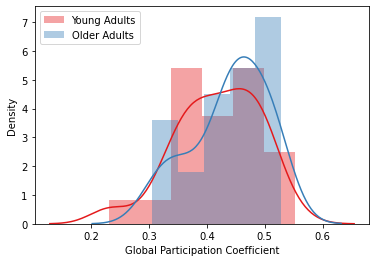

In [23]:
sns.distplot(df[df['Group'] == "Young Adults"]['pc_global'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['pc_global'].dropna(), label = 'Older Adults')
plt.xlabel('Global Participation Coefficient')
plt.legend()
plt.savefig(results_dir + 'global_pc.png', dpi=300)

In [24]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_global'].dropna(), df[df['Group'] == "Older Adults"]['pc_global'].dropna())

Ttest_indResult(statistic=-1.2181621237552402, pvalue=0.22737216836760935)

## Mean FC <a id='fc'></a>

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


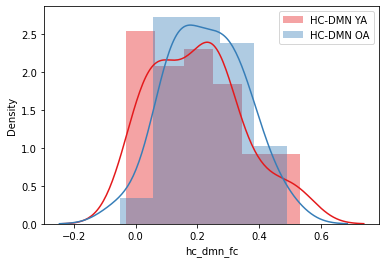

In [25]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_dmn_fc'], label = 'HC-DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_dmn_fc'], label = 'HC-DMN OA')
plt.legend()

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


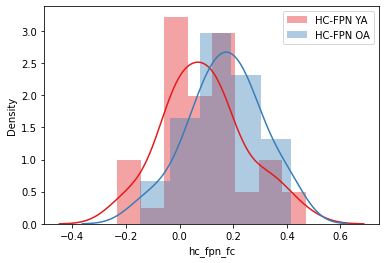

In [26]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], label = 'HC-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_fpn_fc'], label = 'HC-FPN OA')
plt.legend()

In [27]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], df[df['Group'] == "Older Adults"]['hc_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=-2.118269015553221, pvalue=0.037653525419049726)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


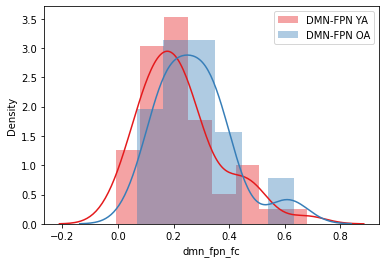

In [28]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], label = 'DMN-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], label = 'DMN-FPN OA')
plt.legend()

In [29]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=-1.5262226325605655, pvalue=0.1313970684582601)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


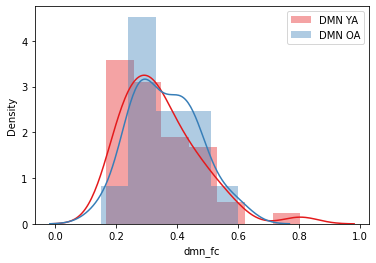

In [30]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fc'], label = 'DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fc'], label = 'DMN OA')
plt.legend()

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


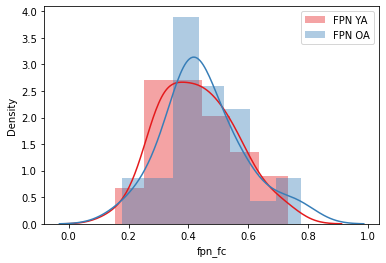

In [31]:
sns.distplot(df[df['Group'] == "Young Adults"]['fpn_fc'], label = 'FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['fpn_fc'], label = 'FPN OA')
plt.legend()

## Regression analyses <a id='reg'></a>

In [32]:
from scipy.stats.mstats import zscore

edge_cols = [col for col in df if col.startswith('net')]

regdf = df[['Group', 'sex', 'age', 'actamp', 'actphi', 'sleep_time_mean_sleep', 'total_ac_mean_active', 'pc_global', 'mod_mean', 'pc_dmn_mean', 'pc_fpn_mean', 'hc_dmn_fc', 'hc_fpn_fc', 'dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'q_global', 'acc_mean_test_log', 'acc_mean_test', 'rt_c_mean_test', 'acc_mean_learning_log', 'rt_c_mean_learning'] + edge_cols]

convert_dict = {'Group': str,
                'sex': str,
                'age': str
               }
  
regdf = regdf.astype(convert_dict)

regdf = regdf.select_dtypes(include=object).dropna().join(regdf.select_dtypes(include=[np.number]).dropna().apply(stats.zscore))
regdf.dropna(subset=['sex'])
regdf = regdf[abs(regdf['actamp']) < 3]

print(regdf.shape)

(66, 61)


In [33]:
df.groupby(['Group', 'sex'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global'].describe()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


age                                               \
                    count   mean   std   min    25%   50%    75%   max   
Group        sex                                                         
Older Adults Female  25.0  66.36  4.54  60.0  63.00  66.0  70.00  76.0   
             Male     2.0  65.00  1.41  64.0  64.50  65.0  65.50  66.0   
Young Adults Female  28.0  21.54  3.82  18.0  18.75  20.0  23.25  30.0   
             Male    15.0  20.47  3.38  18.0  18.50  19.0  20.00  29.0   

                    hc_dmn_fc        ... hc_fpn_fc       q_global              \
                        count  mean  ...       75%   max    count  mean   std   
Group        sex                     ...                                        
Older Adults Female      25.0  0.22  ...      0.26  0.41     23.0  0.31  0.04   
             Male         2.0  0.24  ...      0.20  0.23      2.0  0.28  0.02   
Young Adults Female      28.0  0.22  ...      0.16  0.47     28.0  0.36  0.06   
             Male        15.0  0.18  ...      0.18  0.36     14.0  0.35  0.05   

                                                   
                      min   25%   50%   75%   max  
Group        sex                                   
Older Adults Female  0.23  0.28  0.31  0.34  0.39  
             Male    0.27  0.27  0.28  0.29  0.30  
Young Adults Female  0.18  0.33  0.37  0.40  0.47  
             Male    0.27  0.31  0.34  0.37  0.47  

[4 rows x 32 columns]

In [34]:
regdf.groupby(['Group', 'sex'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global'].describe()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


hc_dmn_fc                                            \
                        count  mean   std   min   25%   50%   75%   max   
Group        sex                                                          
Older Adults Female      22.0  0.17  0.87 -1.08 -0.55  0.08  0.70  2.12   
             Male         2.0  0.28  1.13 -0.52 -0.12  0.28  0.68  1.08   
Young Adults Female      28.0  0.10  1.09 -1.76 -0.66  0.01  0.47  2.44   
             Male        14.0 -0.36  0.93 -1.64 -1.20 -0.27  0.44  1.12   

                    hc_fpn_fc        ...             q_global              \
                        count  mean  ...   75%   max    count  mean   std   
Group        sex                     ...                                    
Older Adults Female      22.0  0.42  ...  0.97  1.95     22.0 -0.44  0.76   
             Male         2.0  0.42  ...  0.58  0.74      2.0 -1.02  0.35   
Young Adults Female      28.0 -0.20  ...  0.31  2.31     28.0  0.40  1.10   
             Male        14.0 -0.19  ...  0.32  1.12     14.0  0.12  0.87   

                                                   
                      min   25%   50%   75%   max  
Group        sex                                   
Older Adults Female -1.84 -0.94 -0.53  0.05  0.82  
             Male   -1.27 -1.15 -1.02 -0.90 -0.77  
Young Adults Female -2.69 -0.22  0.57  1.06  2.13  
             Male   -1.19 -0.50  0.03  0.52  2.24  

[4 rows x 24 columns]

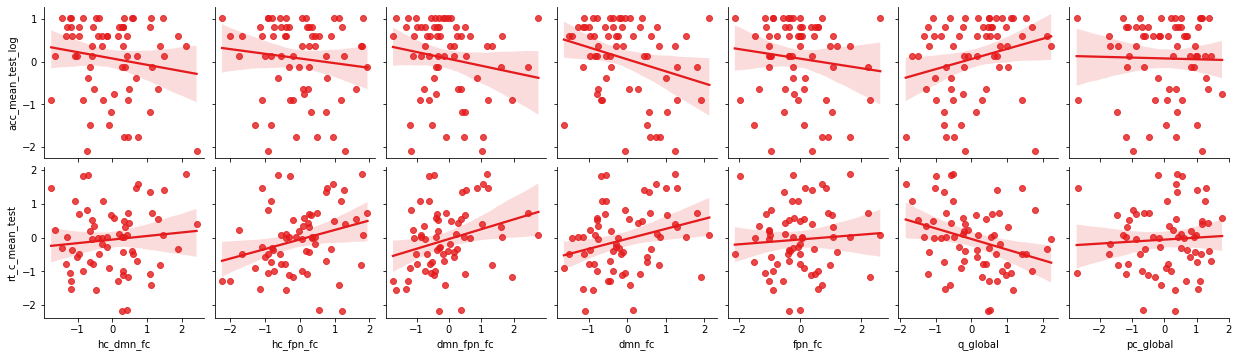

In [35]:
sns.pairplot(regdf[regdf['dmn_fc'] < 3].dropna(), 
             x_vars=['hc_dmn_fc', 'hc_fpn_fc', 'dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'q_global', 'pc_global'], 
             y_vars=['acc_mean_test_log', 'rt_c_mean_test'],
             palette = 'Set1', kind='reg')

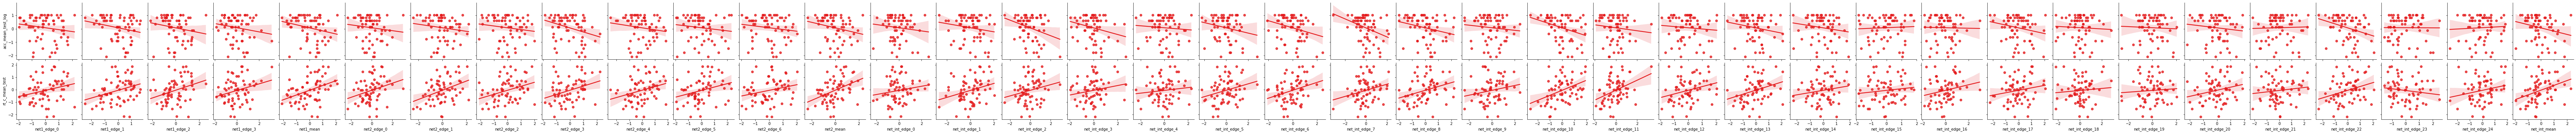

In [36]:
sns.pairplot(regdf[regdf['dmn_fc'] < 3].dropna(), 
             x_vars=edge_cols, y_vars=['acc_mean_test_log', 'rt_c_mean_test'],
             palette = 'Set1', kind='reg')

In [37]:
regdf['GroupBin'] = np.where(regdf['Group'] == 'Young Adults', 0, 1)

### M: DMN-FPN Modularity

In [38]:
medtab = pg.mediation_analysis(data=regdf, x='actamp', 
                               m='mod_mean', 
                               y='acc_mean_test_log', 
                               covar='GroupBin', 
                               alpha=0.05)
# medtab.to_latex('/Users/PSYC-mcm5324/Desktop/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,mod_mean ~ X,0.30,0.15,0.04,9.18e-03,0.59,Yes
1,Y ~ mod_mean,0.28,0.12,0.03,2.65e-02,0.52,Yes
2,Total,0.31,0.15,0.04,1.01e-02,0.61,Yes
3,Direct,0.24,0.15,0.12,-6.26e-02,0.55,No
4,Indirect,0.07,0.06,0.14,-4.68e-03,0.22,No


In [39]:
medtab = pg.mediation_analysis(data=regdf, x='actamp', 
                               m='mod_mean', 
                               y='acc_mean_test_log', 
                               covar=['GroupBin', 'sleep_time_mean_sleep'], 
                               alpha=0.05)
# medtab.to_latex('/Users/PSYC-mcm5324/Desktop/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,mod_mean ~ X,0.32,0.15,0.04,1.26e-02,0.62,Yes
1,Y ~ mod_mean,0.27,0.12,0.03,2.79e-02,0.51,Yes
2,Total,0.25,0.15,0.11,-5.97e-02,0.56,No
3,Direct,0.17,0.16,0.27,-1.39e-01,0.49,No
4,Indirect,0.07,0.05,0.16,6.13e-04,0.22,No


In [40]:
medtab = pg.mediation_analysis(data=regdf, x='actamp', 
                               m='mod_mean', 
                               y='rt_c_mean_test', 
                               covar=['GroupBin'], 
                               alpha=0.05)
# medtab.to_latex('/Users/PSYC-mcm5324/Desktop/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,mod_mean ~ X,0.30,0.15,0.04,9.18e-03,0.59,Yes
1,Y ~ mod_mean,-0.18,0.11,0.12,-3.95e-01,0.05,No
2,Total,-0.25,0.13,0.06,-5.10e-01,0.01,No
3,Direct,-0.21,0.14,0.13,-4.79e-01,0.06,No
4,Indirect,-0.04,0.05,0.22,-1.58e-01,0.02,No


### M: Global Modularity

In [41]:
medtab = pg.mediation_analysis(data=regdf, x='actamp', 
                               m='q_global', 
                               y='acc_mean_test_log', 
                               covar=['GroupBin', 'sleep_time_mean_sleep'], 
                               alpha=0.05)
# medtab.to_latex('/Users/PSYC-mcm5324/Desktop/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,q_global ~ X,0.27,0.15,0.07,-2.53e-02,0.56,No
1,Y ~ q_global,0.32,0.13,0.01,6.47e-02,0.57,Yes
2,Total,0.25,0.15,0.11,-5.97e-02,0.56,No
3,Direct,0.17,0.15,0.27,-1.35e-01,0.48,No
4,Indirect,0.08,0.06,0.20,5.15e-03,0.29,No


### M: Global Modularity

In [42]:
medtab = pg.mediation_analysis(data=regdf, x='actamp', 
                               m='dmn_fc', 
                               y='acc_mean_test_log', 
                               covar=['GroupBin', 'sleep_time_mean_sleep'], 
                               alpha=0.05)
# medtab.to_latex('/Users/PSYC-mcm5324/Desktop/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,dmn_fc ~ X,0.23,0.15,1.48e-01,-0.08,0.54,No
1,Y ~ dmn_fc,-0.38,0.12,1.94e-03,-0.61,-0.15,Yes
2,Total,0.25,0.15,1.12e-01,-0.06,0.56,No
3,Direct,0.35,0.14,1.82e-02,0.06,0.63,Yes
4,Indirect,-0.10,0.07,1.92e-01,-0.25,0.02,No


In [43]:
medtab = pg.mediation_analysis(data=regdf, x='actamp', 
                               m='fpn_fc', 
                               y='acc_mean_test_log', 
                               covar=['GroupBin', 'sleep_time_mean_sleep'], 
                               alpha=0.05)
# medtab.to_latex('/Users/PSYC-mcm5324/Desktop/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,fpn_fc ~ X,0.26,0.16,0.11,-6.34e-02,5.78e-01,No
1,Y ~ fpn_fc,-0.19,0.12,0.12,-4.25e-01,5.22e-02,No
2,Total,0.25,0.15,0.11,-5.97e-02,5.55e-01,No
3,Direct,0.31,0.15,0.05,1.24e-03,6.15e-01,Yes
4,Indirect,-0.06,0.05,0.22,-2.31e-01,1.90e-03,No


In [44]:
medtab = pg.mediation_analysis(data=regdf, x='actamp', 
                               m='dmn_fpn_fc', 
                               y='acc_mean_test_log', 
                               covar=['GroupBin', 'sleep_time_mean_sleep'], 
                               alpha=0.05)
# medtab.to_latex('/Users/PSYC-mcm5324/Desktop/mediation_global.tex')
medtab

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,dmn_fpn_fc ~ X,0.13,0.16,0.41,-0.19,4.50e-01,No
1,Y ~ dmn_fpn_fc,-0.25,0.12,0.04,-0.49,-8.23e-03,Yes
2,Total,0.25,0.15,0.11,-0.06,5.55e-01,No
3,Direct,0.28,0.15,0.06,-0.02,5.83e-01,No
4,Indirect,-0.04,0.05,0.46,-0.19,2.31e-02,No


## Old Plot Code

/usr/local/lib/python3.7/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


β = -0.56, t = -2.01, p = 0.049


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.730
Date:                Mon, 28 Feb 2022   Prob (F-statistic):             0.0514
Time:                        17:36:24   Log-Likelihood:                -88.949
No. Observations:                  66   AIC:                             185.9
Df Residuals:                      62   BIC:                             194.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.2632      0.220     -1.199      0.235      -0.702       0.176
Group[T.Young Adults]               0.3296      0.267      1.237      0.221      -0.203       0.862
hc_fpn_fc                           0.2042      0.237      0.861      0.392      -0.270       0.678
hc_fpn_fc:Group[T.Young Adults]    -0.5617      0.280     -2.008      0.049      -1.121      -0.002
==============================================================================
Omnibus:                       11.103   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.554
Skew:                          -1.006   Prob(JB):                      0.00310
Kurtosis:                       3.395   Cond. No.                         4.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 2400x1800 with 0 Axes>

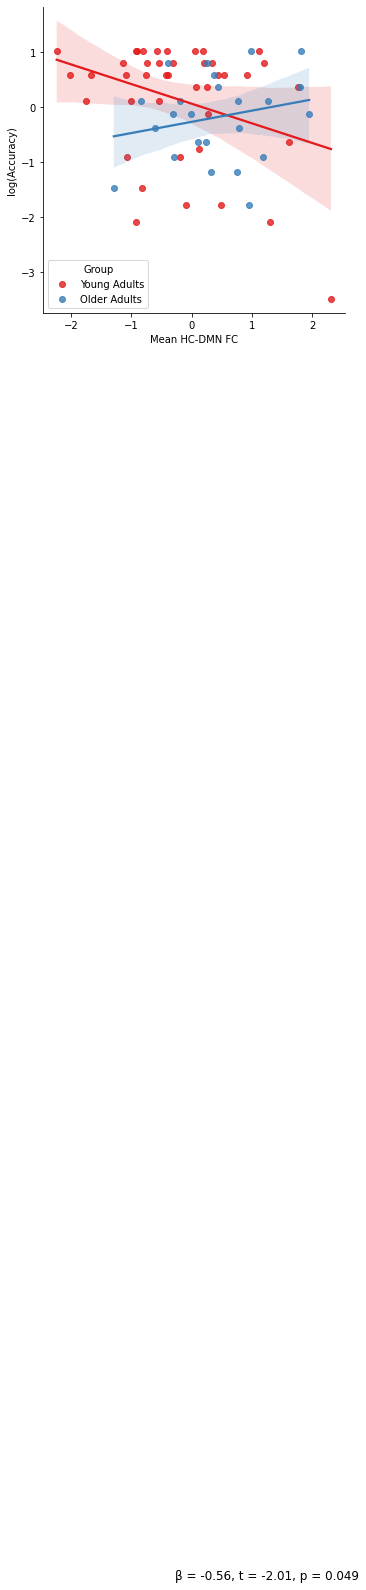

In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'hc_fpn_fc:Group[T.Young Adults]'
plot_title = 'HC-FPN FC'
x_pos = .5
y_pos = -3.4

model = smf.ols(formula='acc_mean_test_log ~ hc_fpn_fc * Group', data=regdf[abs(regdf['hc_fpn_fc']) < 3]).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=regdf[abs(regdf['hc_fpn_fc']) < 3], x='hc_fpn_fc', y="acc_mean_test_log", hue='Group', palette = 'Set1', legend_out=False)
plt.ylabel('log(Accuracy)'); plt.xlabel('Mean HC-DMN FC')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.savefig(results_dir + 'scatter-hc-dmn-fc_accuracy.png', dpi=300, bbox_inches="tight")

summary